<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimal Threshold for Random Forest: 0.5926
Nested CV Mean Accuracy Score for Random Forest: 0.6538
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for Random Forest: {'n_estimators': 20, 'min_samples_split': 25, 'min_samples_leaf': 25, 'max_features': None, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Optimal Threshold for Decision Tree: 0.7391
Nested CV Mean Accuracy 

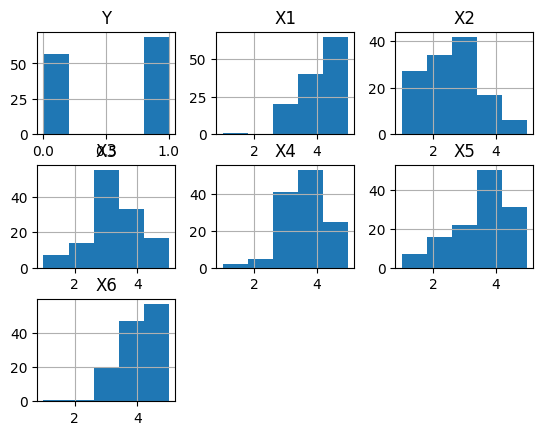

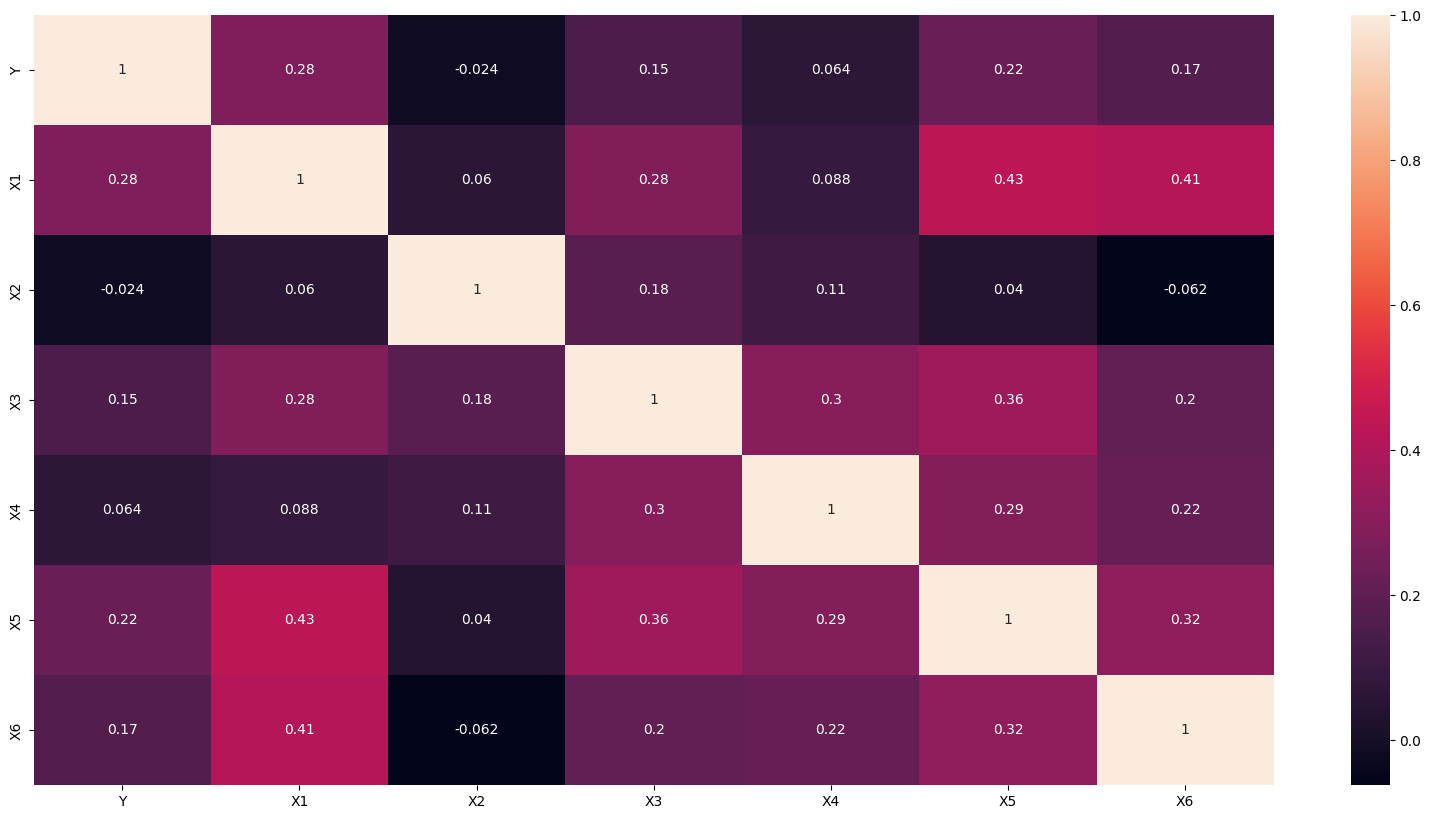

In [137]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#loading the data
happy=pd.read_csv('ACME-HappinessSurvey2020.csv')
happy.head()

happy.shape

happy.info()

#See columns in data
happy.columns

happy.describe()

happy.isnull().sum() #There are no null variables, all numerical data

#Data Exploration

happy.hist(bins=5)

#Visualisation of target column relative frequency
happy['Y'].value_counts().plot(kind='pie',autopct='%1.2f%%',title='Proportion of Happy Customers')
#Data is not completely unbalanced

#Correlation between variables
plt.figure(figsize=(20,10))
sns.heatmap(happy.corr(),annot=True)
happy.corr() #No multicollinearity

#Data Modeling

#Importing "train_test-split" function to test the model
from sklearn.model_selection import train_test_split

#Splitting the data
X=happy.drop(['Y'],axis=1)
y=happy['Y']

#Model Comparison using automatic nested cross-validation
# Compare classification algorithms
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, balanced_accuracy_score
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=246)
#One Hot Encoding train and test set separately
ohe=OneHotEncoder(sparse=False,handle_unknown="ignore")

# Set up the inner cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Randomized Search with Random Forest Classifier
rf = RandomForestClassifier(random_state=0)
#Define the hyperparameter grid
rf_param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1, 2, 4, 25],
              'min_samples_split': [2, 5, 10, 25],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}
grid_search_rf = RandomizedSearchCV(rf, rf_param_grid, cv=inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True, random_state=0)


# Set up the outer cross-validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

holder_acc_rf = []

# (ii) Learn the feature encoder and map values
ohe.fit(X_train)
X_train = np.concatenate([X_train,ohe.transform(X_train)],axis=1)
X_test = np.concatenate([X_test, ohe.transform(X_test)], axis=1)

# (iii) Do Inner-CV on the training data
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_estimator_.score(X_test, y_test)

# (iv) Determine optimal threshold
# Alternative approach with operating threshold optimizer
predicted_probs_rf = grid_search_rf.predict_proba(X_train)[:,1]
# Figure out which threshold gets the best accuracy score
threshold = []
accuracy = []

for p in np.unique(predicted_probs_rf):
  threshold.append(p)
  y_pred = (predicted_probs_rf >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_train,y_pred))

threshold_optimal_rf=threshold[np.argmax(accuracy)]
print(f"Optimal Threshold for Random Forest: {threshold_optimal_rf:.4f}")

# (v) Make final prediction (save this)
test_acc_rf = accuracy_score(y_test, grid_search_rf.predict_proba(X_test)[:,1] > threshold_optimal_rf)
holder_acc_rf.append(test_acc_rf)
# accuracy_score(y_test, grid_search_rf.predict(X_test))
print(f"Nested CV Mean Accuracy Score for Random Forest: {np.mean(holder_acc_rf):.4f}")
print(f"Best Parameters for Random Forest: {grid_search_rf.fit(X_train, y_train).best_params_}")

# We will now use Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=242)
#Define the hyperparameter grid
dt_param_grid = {'max_depth': [1, 10, 20, 30, 50],
              'max_features': [1, 2, 3, 4, 5]}
grid_search_dt = RandomizedSearchCV(dt, dt_param_grid, cv=inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True, random_state=25)

holder_acc_dt = []

# (iii) Do Inner-CV on the training data
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_estimator_.score(X_test, y_test)

# (iv) Determine optimal threshold
# Alternative approach with operating threshold optimizer
predicted_probs_dt = grid_search_dt.predict_proba(X_train)[:,1]
# Figure out which threshold gets the best accuracy score
threshold_dt = []
accuracy_dt = []

for p in np.unique(predicted_probs_dt):
  threshold_dt.append(p)
  y_pred_dt = (predicted_probs_dt >= p).astype(int)
  accuracy_dt.append(balanced_accuracy_score(y_train,y_pred_dt))

threshold_optimal_dt=threshold_dt[np.argmax(accuracy_dt)]
print(f"Optimal Threshold for Decision Tree: {threshold_optimal_dt:.4f}")

# (v) Make final prediction (save this)
test_acc_dt = accuracy_score(y_test, grid_search_dt.predict_proba(X_test)[:,1] > threshold_optimal_dt)
holder_acc_dt.append(test_acc_dt)
# accuracy_score(y_test, grid_search_rf.predict(X_test))
print(f"Nested CV Mean Accuracy Score for Decision Tree: {np.mean(holder_acc_dt):.4f}")
print(f"Best Parameters for Decision Tree: {grid_search_dt.fit(X_train, y_train).best_params_}")

# We will now use Logistic Regression
lg = LogisticRegression(random_state=0)
#Define the hyperparameter grid
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
grid_search_lg = RandomizedSearchCV(lg, space, cv=inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True, random_state=0)

holder_acc_lg = []

# (iii) Do Inner-CV on the training data
grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_estimator_.score(X_test, y_test)

# (iv) Determine optimal threshold
# Alternative approach with operating threshold optimizer
predicted_probs_lg = grid_search_lg.predict_proba(X_train)[:,1]
# Figure out which threshold gets the best accuracy score
threshold_lg = []
accuracy_lg = []

for p in np.unique(predicted_probs_lg):
  threshold_lg.append(p)
  y_pred_lg = (predicted_probs_lg >= p).astype(int)
  accuracy_lg.append(balanced_accuracy_score(y_train,y_pred_lg))

threshold_optimal_lg=threshold_lg[np.argmax(accuracy_lg)]
print(f"Optimal Threshold for Logistic Regression: {threshold_optimal_lg:.4f}")

# (v) Make final prediction (save this)
test_acc_lg = accuracy_score(y_test, grid_search_lg.predict_proba(X_test)[:,1] > threshold_optimal_lg)
holder_acc_lg.append(test_acc_lg)
# accuracy_score(y_test, grid_search_rf.predict(X_test))
print(f"Nested CV Mean Accuracy Score for Logistic Regression: {np.mean(holder_acc_lg):.4f}")
print(f"Best Parameters for Logistic Regression: {grid_search_lg.fit(X_train, y_train).best_params_}")

# Feature Selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

holder_features = []
holder_feat_freq = []
for n_features in range(1,7):
    holder_i = []
    for i in range(0,50):
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=i)
        dt_best=DecisionTreeClassifier(max_features=2, max_depth=10, random_state=241)
        chi2_features = SelectKBest(chi2, k=n_features)
        X_kbest = chi2_features.fit_transform(X_train2,y_train2)
        chi2_features.get_support()
        selected_feat=X_train2.columns[(chi2_features.get_support())]
        holder_feat_freq.append(selected_feat)
        X_train_sub = X_train2[selected_feat]
        X_test_sub = X_test2[selected_feat]
        #Two models
        dt_full = dt_best.fit(X_train2, y_train2)
        dt_sub = dt_best.fit(X_train_sub, y_train2)
        # Unbiased estimate of OOF performance
        acc_i = accuracy_score(y_test2, dt_sub.predict(X_test_sub))
        holder_i.append(acc_i)
    acc_n = np.mean(holder_i)
    holder_features.append((n_features, round(acc_n,4)))

#Accuracy per number of features                          
print(holder_features)
#[(1, 0.23525), (2, 0.556346), ...]

#Flattening the holder_feat_freq list in order to find the frequency of each unique object
print(f"Number of times X1 appears in list: {[ item for sublist in holder_feat_freq for item in sublist ].count('X1')}")
print(f"Number of times X2 appears in list: {[ item for sublist in holder_feat_freq for item in sublist ].count('X2')}")
print(f"Number of times X3 appears in list: {[ item for sublist in holder_feat_freq for item in sublist ].count('X3')}")
print(f"Number of times X4 appears in list: {[ item for sublist in holder_feat_freq for item in sublist ].count('X4')}")
print(f"Number of times X5 appears in list: {[ item for sublist in holder_feat_freq for item in sublist ].count('X5')}")
print(f"Number of times X6 appears in list: {[ item for sublist in holder_feat_freq for item in sublist ].count('X6')}")

